In [1]:
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [2]:
# helper function
def read_midi(path):
    mido_obj = mid_parser.MidiFile(path)
    tick_per_beat = mido_obj.ticks_per_beat

    notes = [] 
    for instrument in mido_obj.instruments:
        for note in instrument.notes:
            notes.append(note)

    # sort by start time
    notes.sort(key=lambda note:note.start)
    return notes,tick_per_beat

def write_midi(notes,path='out.mid',tick_per_beat=480):
    out = mid_parser.MidiFile()
    out.ticks_per_beat = tick_per_beat
    out.instruments = [ct.Instrument(program=0,is_drum=False,name='post-processed piano')]
    for note in notes:
        assert(note.velocity)
        out.instruments[0].notes.append(ct.Note(start=note.start,end=note.end,pitch=note.pitch,velocity=note.velocity))
    out.dump(path)

def find_note_idx_before(beat):
    # binary search
    target = beat*tick_per_beat-1
    left=0
    right=len(notes)-1
    middle=(left+right+1)//2
    while left<right:
        if notes[middle].start == target:
            if notes[middle+1].start==target:
                left=middle+1
            else:
                break
        elif notes[middle].start<target:
            left=middle
        else:
            right=middle-1
        middle=(left+right+1)//2
    return middle

def get_centers_per_beat():
    # find centers
    centers_per_beat=[]

    ahead=2
    after=2

    start=ahead
    end=(notes[-1].start//tick_per_beat - after) +1

    trace_start_idx=0
    pitch_range = linspace(0,127)
    for beat in range(start,end):
        notes_within_window = notes[trace_start_idx:find_note_idx_before(beat+after+1)+1]
        pitches_within_window = np.array([note.pitch for note in notes_within_window])

        # use KDE for clustering(intervaling)(determine the center line for left/right hand respectively)
        pitches_within_window = pitches_within_window.reshape(-1,1)
        kernel_size=6
        #interatve clustering
        while True:
            kde = KernelDensity(kernel='gaussian', bandwidth=kernel_size).fit(pitches_within_window)
            kde_val = kde.score_samples(pitch_range.reshape(-1,1))
            # visualization: distribution of notes inside the window
            # plot(pitch_range, kde_val)
            minima, maxima = argrelextrema(kde_val, np.less)[0], argrelextrema(kde_val, np.greater)[0]
            
            #termination check
            if len(minima)>=1 and len(maxima)>=2:
                break
            else:
                kernel_size*=0.5
                assert(kernel_size>=0.001)

        # cluster assignment
        cutoff=min(pitch_range[minima])
        cluster_1_candidate = pitch_range[ maxima[pitch_range[maxima]<cutoff] ]
        cluster_2_candidate = pitch_range[ maxima[pitch_range[maxima]>cutoff] ]
        assert(len(cluster_1_candidate)>=1)
        assert(len(cluster_2_candidate)>=1)
        clusters= sorted([round(max(cluster_1_candidate)), round(max(cluster_2_candidate))])
        centers_per_beat.append(clusters)

    # padding for front and end
    centers_per_beat = ([centers_per_beat[0]]*ahead) + centers_per_beat + ([centers_per_beat[-1]]*after)
    centers_per_beat = np.array(centers_per_beat)
    
    #smooth the line
    kernel_size=4
    centers_per_beat[:,0]=gaussian_filter1d(centers_per_beat[:,0], kernel_size)
    centers_per_beat[:,1]=gaussian_filter1d(centers_per_beat[:,1], kernel_size)
    
    return np.array(centers_per_beat)

In [3]:
# filter long duration notes
def trim_long_notes(notes, threshold=4):
    def trim(note):
        if note.end-note.start>threshold*tick_per_beat:
            note.end = note.start+threshold*tick_per_beat
        return note
    return list(map(trim, notes))

In [4]:
def octave_transpose(transpose_notes):
    # octave transpose
    # for simplicity, use semitone instead of octave
    max_semitone_distance=15 #should >12

    centers_per_beat = get_centers_per_beat()
    transpose_track=[]
    skip_track=[]
    count=0
    skip_count=0

    for note_idx,note in enumerate(transpose_notes):
        current_beat=note.start//tick_per_beat
        centers = centers_per_beat[current_beat]
        abs_distance_to_centers=abs(note.pitch - centers)
        closest_center=np.argmin(abs_distance_to_centers)

        if abs_distance_to_centers[closest_center]>max_semitone_distance:
            # transpose
            if note.pitch>centers[closest_center]:
                # transpose downward 
                # skip right hand first
                # TODO: later figure out how to avoid transposing melody's note
                if closest_center==0: 
                    transpose_notes[note_idx].pitch-=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                    count+=1
                else:
                    skip_count+=1
            else:
                # transpose upward
                transpose_notes[note_idx].pitch+=12*( ((abs_distance_to_centers[closest_center]-max_semitone_distance)//12) +1)
                count+=1
    
    # visualization : center line of left/right hand
    print('transposed',count,'notes',', skipped',skip_count)
    plot(centers_per_beat)
    
    return transpose_notes

transposed 910 notes , skipped 259
out1.mid


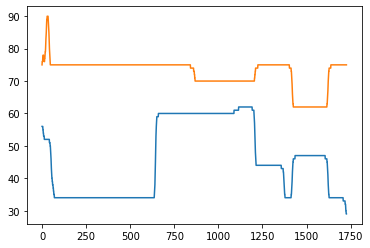

In [5]:
# global variable
#   tick_per_beat
#   notes

# main
notes,tick_per_beat = read_midi("piano.mid")
notes = trim_long_notes(notes)
notes = octave_transpose(notes)
write_midi(notes, "out1.mid", tick_per_beat)

In [6]:
len(notes)

7098